In [1]:
!pip install scikit-optimize
!pip install optuna

     |████████████████████████████████| 100 kB 4.7 MB/s 
     |████████████████████████████████| 308 kB 31.5 MB/s 
     |████████████████████████████████| 209 kB 57.0 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 144 kB 68.3 MB/s 
     |████████████████████████████████| 111 kB 70.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=34ad026f1c064bd35a7c460667719f6e2ddcfee6d851804af78f154c4631af5b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

import skopt
from skopt.space import Real, Categorical, Integer

import optuna
from optuna.visualization import plot_intermediate_values

import warnings
warnings.filterwarnings('ignore')

import time
%matplotlib inline

In [2]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [3]:
df_ = pd.read_csv('/content/train_df_step1.csv', index_col='Id')
df_t_= pd.read_csv('/content/test_df_step1.csv', index_col='Id')
df_

,MSSubClass,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,BsmtFullBath,BsmtHalfBath,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,YrSold,SaleType,SaleCondition,MoSold_sin,MoSold_cos,RenovatedY/N,AgeWhenSold,totBath,TotalBsmtFinSF,BsmtFinSF,2ndFloorY/N,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,SalePrice_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,3.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706,1.0,150,856,GasA,5.0,Y,SBrkr,854,1,0,...,0,Attchd,2003.0,2.0,2,548,3.0,3.0,2.0,0,61,2008,WD,Normal,8.660254e-01,5.000000e-01,no,5,3.5,706,706,1,4,274.000000,61,61,1,0,0,0,0,0,0,0,6.752270,5.364807,7.444249,9.041922,12.247694,8.360773
2,20,RL,Pave,3.0,Lvl,FR2,0.0,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978,1.0,284,1262,GasA,5.0,Y,SBrkr,0,0,1,...,1,Attchd,1976.0,2.0,2,460,3.0,3.0,2.0,298,0,2007,WD,Normal,5.000000e-01,-8.660254e-01,no,31,2.5,978,978,0,2,230.000000,298,0,0,0,0,0,0,0,0,0,7.140453,5.348694,7.140453,9.169518,12.109011,8.239065
3,60,RL,Pave,2.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486,1.0,434,920,GasA,5.0,Y,SBrkr,866,1,0,...,1,Attchd,2001.0,2.0,2,608,3.0,3.0,2.0,0,42,2008,WD,Normal,-1.000000e+00,-1.836970e-16,yes,7,3.5,486,486,1,2,304.000000,42,42,1,0,0,0,0,0,0,0,6.824374,5.695974,7.487734,9.328123,12.317167,8.410053
4,70,RL,Pave,2.0,Lvl,Corner,0.0,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216,1.0,540,756,GasA,4.0,Y,SBrkr,756,1,0,...,1,Detchd,1998.0,1.0,3,642,3.0,3.0,2.0,0,35,2006,WD,Abnorml,8.660254e-01,5.000000e-01,yes,91,2.0,216,216,1,3,214.000000,35,307,1,0,0,1,0,0,0,0,6.867974,5.502424,7.448334,9.164296,11.849398,8.340456
5,60,RL,Pave,2.0,Lvl,FR2,0.0,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655,1.0,490,1145,GasA,5.0,Y,SBrkr,1053,1,0,...,1,Attchd,2000.0,2.0,3,836,3.0,3.0,2.0,192,84,2008,WD,Normal,-2.449294e-16,1.000000e+00,no,8,3.5,655,655,1,4,278.666667,276,84,1,0,0,0,0,0,0,0,7.043160,5.498079,7.695303,9.565214,12.429216,8.619930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,20,FV,Pave,3.0,Lvl,Inside,0.0,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,410,1.0,811,1221,GasA,5.0,Y,SBrkr,0,1,0,...,0,Attchd,2004.0,2.0,2,400,3.0,3.0,2.0,0,113,2009,WD,Normal,-8.660254e-01,5.000000e-01,yes,5,3.0,410,410,0,3,200.000000,113,113,1,0,0,0,0,0,0,0,7.107425,5.315666,7.107425,8.922658,12.128111,8.206038
1456,60,RL,Pave,3.0,Lvl,Inside,0.0,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3.0,3.0,PConc,4.0,3.0,1.0,1.0,0,1.0,953,953,GasA,5.0,Y,SBrkr,694,0,0,...,1,Attchd,1999.0,2.0,2,460,3.0,3.0,2.0,0,40,2007,WD,Normal,-8.660254e-01,-5.000000e-01,yes,8,2.5,0,0,1,3,230.000000,40,40,1,0,

In [4]:
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition',
       'Street', 'CentralAir', 'RenovatedY/N', '2ndFloorY/N', 'PorchY/N',
       'BsmtFinSF2_cat', 'LowQualFinSF_cat', 'EnclosedPorch_cat',
       '3SsnPorch_cat', 'ScreenPorch_cat', 'MiscVal_cat', 'PoolArea_cat']

ordinal = ['MSSubClass', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'YrSold', 'AgeWhenSold', 'totBath', 'OtherRooms']

continuous = ['2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
       'GarageSpaceForCar', 'MasVnrArea', 'MoSold_cos', 'MoSold_sin',
       'OpenPorchSF', 'TotalBsmtFinSF', 'TotalBsmtSF', 'TotalPorchSF',
       'WoodDeckOpenPorch', 'WoodDeckSF', '1stFlrSF_log',
       'AverageRoomSF_log', 'GrLivArea_log', 'LotArea_log',
       'SalePrice_log', 'totSqFt_log']

In [5]:
# def standartize(df, columns):
#     st_df = df.copy()
    
#     scaler = StandardScaler()
    
#     st_df[columns] = scaler.fit_transform(df[columns])
#     print(df.shape, st_df.shape)
    
#     return st_df


# st_train_df = standartize(df_, ordinal + continuous)

# arr_to_standartize_test = ordinal + continuous
# arr_to_standartize_test.remove('SalePrice_log')
# st_test_df = standartize(df_t_, arr_to_standartize_test)

In [6]:
def one_hot_enc(train_df, test_df, columns):
    train_df['Status'] = 'Train'
    test_df['Status'] = 'Test'
    
    app_df = train_df.append(test_df)
    
    merded_app_df = pd.concat([pd.get_dummies(app_df[columns], drop_first=True), 
                           app_df.loc[:, app_df.columns[~app_df.columns.isin(columns)]]], axis=1)
    
    train_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Train']
    train_df_enc.drop('Status', axis=1, inplace=True)

    test_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Test']
    test_df_enc.drop(['Status', 'SalePrice_log'], axis=1, inplace=True)


    print(train_df_enc.shape, test_df_enc.shape)
    
    return train_df_enc, test_df_enc


train_df, test_df = one_hot_enc(df_, df_t_, nominal)

(1252, 207) (1459, 206)


In [7]:
# serial_corr_cols_to_drop = ['YrSold', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea_log', 'BsmtFinSF2_cat',
#         '1stFlrSF_log', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#         'BsmtFinSF1', 'BsmtFinSF2_cat', 'BsmtFinSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
#         'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch_cat',
#         '3SsnPorch_cat', 'PoolArea_cat', 'RoofStyle', 'RoofMatl', 'Condition2', 'BsmtFinType1', 'LandSlope', 'Exterior2nd']

# train_df1 = df_.copy()
# test_df1 = df_t_.copy()


# train_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)
# test_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)

# nominal1 = list(set(nominal) - set(serial_corr_cols_to_drop))
# ordinal1 = list(set(ordinal) - set(serial_corr_cols_to_drop))
# continuous1 = list(set(continuous) - set(serial_corr_cols_to_drop))


# st_train_df1 = standartize(train_df1, ordinal1 + continuous1)

# arr_to_standartize_test1 = ordinal1 + continuous1
# arr_to_standartize_test1.remove('SalePrice_log')
# st_test_df1 = standartize(test_df1, arr_to_standartize_test1)

In [8]:
# train_df1, test_df1 = one_hot_enc(st_train_df1, st_test_df1, nominal1)

In [9]:
X = train_df.drop('SalePrice_log', axis=1)
y = train_df['SalePrice_log']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

# X1 = train_df.drop('SalePrice_log', axis=1)
# y1 = train_df['SalePrice_log']
# x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, shuffle=True, test_size=0.2)

kfolds = KFold(n_splits=6, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y, kfolds=kfolds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=2))
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds, n_jobs=2)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfolds, n_jobs=2)
    return rmse, mae, r2

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  Mean RMSE: {round(rmse_.mean(),7)} Std RMSE: {round(rmse_.std(),7)}')
    print(f'MAE CV: {mae_}  Mean MAE: {round(mae_.mean(),7)} Std MAE: {round(mae_.std(),7)}')
    print(f'R2 CV: {r2_}  Mean R2: {round(r2_.mean(),7)} Std R2: {round(r2_.std(),7)}')

### XGB Regressor

#### Bayes

In [16]:
%%time

xgbr_params = {
    
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(25, 1500, prior='uniform'),
    'subsample':  Real(0.5, 1., prior='uniform'),   
    'max_depth': Integer(1, 23, prior='uniform'),
    'min_child_weight': Integer(1, 9, prior='uniform'),
    # 'gamma': Real(0., 5,  prior='uniform'),
    # 'max_delta_step': Integer(0, 5, prior='uniform'),
    # 'colsample_bytree': Real(0., 1.,  prior='uniform'),
    'reg_alpha': Real(0., 6., prior='uniform'),
    'reg_lambda': Real(0., 6.)

}

search_xgbr = skopt.BayesSearchCV(estimator=xgb.XGBRegressor(),
                                search_spaces=xgbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=6,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=2,
                                 verbose=10
                                )

search_xgbr_ = search_xgbr.fit(X, y)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   29.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   58.9s remaining:   29.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   16.6s remaining:    8.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   24.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    9.7s remaining:    4.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   14.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   26.2s remaining:   13.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   39.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   42.9s remaining:   21.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.1min finished


[00:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 25.1 s, sys: 240 ms, total: 25.4 s
Wall time: 4min 15s


In [17]:
-search_xgbr.best_score_, np.sqrt(-search_xgbr.best_score_)

(0.01293442655762648, 0.1137296204057082)

In [18]:
dict(search_xgbr.best_params_)

{'learning_rate': 0.01915381554250815,
 'max_depth': 9,
 'min_child_weight': 4,
 'n_estimators': 1249,
 'reg_alpha': 0.40622655343810965,
 'reg_lambda': 5.747304493474968,
 'subsample': 0.6582147957202108}

#### Optuna

In [10]:
def objective_xgbr(trial, X, y, cv, scoring):
    
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 23),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 9),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0., 1., step=0.05),
        'subsample': trial.suggest_float("subsample", 0.5, 1., step=0.05),
        'reg_alpha':  trial.suggest_float("reg_alpha", 0., 6., step=0.001),
        'reg_lambda': trial.suggest_float("reg_lambda", 0., 6., step=0.001),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int("n_estimators", 25, 1500, step=25),
        
    }
    
    
    gr_reg = xgb.XGBRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse


In [11]:
%%time

sampler_xgbr = optuna.samplers.TPESampler(seed=7)

# Create study that minimizes
study_xgbr = optuna.create_study(direction="minimize", sampler=sampler_xgbr)

# Pass additional arguments inside another function
func_xgbr = lambda trial: objective_xgbr(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study_xgbr.optimize(func_xgbr, timeout=60*110, show_progress_bar =True)


print(f"Optimized RMSE: {study_xgbr.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.10958
CPU times: user 34 s, sys: 2.69 s, total: 36.7 s
Wall time: 1h 50min 41s


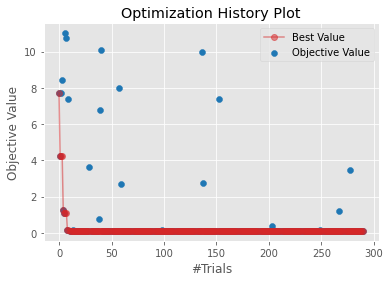

In [12]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgbr);

In [13]:
study_xgbr.best_value, study_xgbr.best_params

(0.10957700210630263,
 {'colsample_bytree': 0.9,
  'learning_rate': 0.026354267881767892,
  'max_depth': 2,
  'min_child_weight': 7,
  'n_estimators': 1375,
  'reg_alpha': 0.379,
  'reg_lambda': 1.188,
  'subsample': 0.6})

In [ ]:
def objective(trial, X, y, cv, scoring):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 9),
        'gamma': trial.suggest_float("gamma", 0., 5, step=0.001),
        'max_delta_step': trial.suggest_int("max_delta_step", -5, 5),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0., 1., step=0.05),
        'subsample': trial.suggest_float("subsample", 0.5, 1., step=0.05),
        'reg_alpha':  trial.suggest_float("reg_alpha", 0., 6., step=0.001),
        'reg_lambda': trial.suggest_float("reg_lambda", 0., 6., step=0.001),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int("n_estimators", 50, 900, step=25),
        
    }
    
    
    gr_reg = xgb.XGBRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse




In [ ]:
%%time

sampler = optuna.samplers.TPESampler(seed=7)

# Create study that minimizes
study = optuna.create_study(direction="minimize", sampler=sampler)

# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study.optimize(func, timeout=60*1, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.37440
CPU times: user 720 ms, sys: 136 ms, total: 856 ms
Wall time: 1min 4s


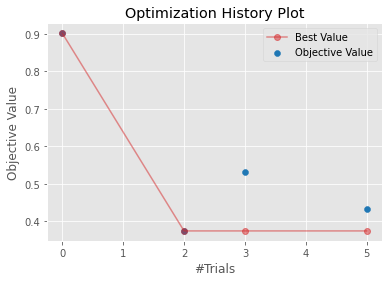

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study);

In [ ]:
%%time

gbr_params = {
    'loss': ['huber'],
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(25, 1500, prior='uniform'),
    'subsample':  Real(0.6, 1., prior='uniform'),   
    'max_depth': Integer(1, 23, prior='uniform'),
    'min_samples_split': Real(0.00015, 0.4, prior='uniform'),
    'min_samples_leaf': Real(0.0007, 0.03, prior='uniform'),
    'max_features': Real(0.01, 1., prior='uniform')
}

search_gbr = skopt.BayesSearchCV(estimator=GradientBoostingRegressor(),
                                search_spaces=gbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=50,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=2,
                                 verbose=10
                                )

search_gbr_ = search_gbr.fit(X, y)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    9.5s remaining:    4.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   14.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   12.7s remaining:    6.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   18.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   12.2s remaining:    6.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   18.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   24.5s remaining:   12.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   36.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   36.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   19.9s remaining:   10.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   29.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   14.0s remaining:    7.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   20.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   39.4s remaining:   19.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   59.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   59.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    6.0s remaining:    3.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   11.5s remaining:    5.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   17.3s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    4.3s remaining:    2.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.3s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   31.4s remaining:   15.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   47.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   47.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    9.1s remaining:    4.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    5.6s remaining:    2.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.4s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.5s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    5.2s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   14.8s remaining:    7.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   22.1s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    4.1s remaining:    2.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.2s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   40.9s remaining:   20.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.0min finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.4s remaining:    3.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   11.1s remaining:    5.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   16.5s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    5.2s remaining:    2.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.7s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   22.2s remaining:   11.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   33.1s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    5.5s remaining:    2.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.1s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    8.0s remaining:    4.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   12.1s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.4s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   13.6s remaining:    6.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   20.3s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    5.2s remaining:    2.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    4.8s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   11.0s remaining:    5.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   16.5s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   16.8s remaining:    8.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   25.1s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    9.1s remaining:    4.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   10.1s remaining:    5.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   15.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   38.0s remaining:   19.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   56.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   56.4s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   20.6s remaining:   10.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   30.8s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.5s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   14.9s remaining:    7.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   22.3s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    8.5s remaining:    4.2s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   12.7s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   38.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:  1.3min remaining:   38.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.9min finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.6s remaining:    3.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.4s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    4.8s remaining:    2.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    7.2s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   35.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:  1.2min remaining:   36.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.8min finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   17.1s remaining:    8.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   25.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    5.9s remaining:    2.9s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    8.8s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:  3.8min remaining:  1.9min
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  5.7min finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    6.5s remaining:    3.2s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    9.6s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.3s remaining:    3.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.9s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.7s remaining:    3.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.5s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   13.2s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   15.7s remaining:    7.8s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   23.4s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    6.3s remaining:    3.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    9.4s finished


CPU times: user 2min 44s, sys: 1min 20s, total: 4min 4s
Wall time: 25min 55s


In [ ]:
-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

(0.09234960135226733, 0.3038907720748811)

In [ ]:
dict(search_gbr.best_params_)

{'learning_rate': 0.0237561655340257,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.2961866687064254,
 'min_samples_leaf': 0.025738496329078393,
 'min_samples_split': 0.316902177562381,
 'n_estimators': 1031,
 'subsample': 0.7488889453990157}

In [ ]:
params_gbr = {
  'learning_rate': 0.0237561655340257,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.2961866687064254,
 'min_samples_leaf': 0.025738496329078393,
 'min_samples_split': 0.316902177562381,
 'n_estimators': 1031,
 'subsample': 0.7488889453990157
}

tuned_gbr_booster = GradientBoostingRegressor(**params_gbr)

rmse_tuned_gbr_booster, mae_tuned_gbr_booster, r2_tuned_gbr_booster = cv_rmse(tuned_gbr_booster, X, y)
display_cv_scores(rmse_tuned_gbr_booster, mae_tuned_gbr_booster, r2_tuned_gbr_booster)

RMSE CV: [0.29899641 0.27864847 0.32711591 0.30742636 0.32340863 0.30256528]  Mean RMSE: 0.3063602 Std RMSE: 0.0161201
MAE CV: [0.21546347 0.20274966 0.21724545 0.21115508 0.21616147 0.20457792]  Mean MAE: 0.2112255 Std MAE: 0.005695
R2 CV: [0.89589935 0.92896019 0.89088054 0.90414136 0.90467087 0.90231536]  Mean R2: 0.9044779 Std R2: 0.0119909


In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2